In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import day_abbr, month_abbr
import time
import itertools
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.ensemble import IsolationForest

## Load and explore the data set:

In [2]:
df = read_csv('solar_final_data.csv' ,index_col=0)
df.tail()

,costumer,GC,hourofday,minuteofhour,dayofweek,dayofmonth,monthofyear,year,Anomaly
350875,215,0.227,21,30,6,30,6,2013,0
350876,215,0.275,22,0,6,30,6,2013,0
350877,215,0.222,22,30,6,30,6,2013,0
350878,215,0.131,23,0,6,30,6,2013,0
350879,215,0.071,23,30,6,30,6,2013,0


In [3]:
df.dtypes

costumer          int64
GC              float64
hourofday         int64
minuteofhour      int64
dayofweek         int64
dayofmonth        int64
monthofyear       int64
year              int64
Anomaly           int64
dtype: object

In [4]:
# check the data features variances
df.var()

costumer        6208.177693
GC                 0.083311
hourofday         47.916803
minuteofhour     225.000641
dayofweek          4.002680
dayofmonth        77.509242
monthofyear       11.899435
year               0.499301
Anomaly            0.033160
dtype: float64

#### Ordinal Encoding of categorical features:

In [5]:
Enc = OrdinalEncoder()
df["year"] = Enc.fit_transform(df[["year"]]).astype('int64')
df[["year"]].value_counts()

year
1       175680
0        88320
2        86880
dtype: int64

In [6]:
Enc_1 = OrdinalEncoder()
df["costumer"] = Enc_1.fit_transform(df[["costumer"]]).astype('int64')
df[["costumer"]].value_counts()

costumer
0           35088
1           35088
2           35088
3           35088
4           35088
5           35088
6           35088
7           35088
8           35088
9           35088
dtype: int64

#### Calculate the percentage of each class:

* We have 3:100 class distribution, which mean the we have a severe class imbalance.
* Imbalance ratio= The number of positive instances/The number of negative instances

In [7]:
round(df.Anomaly.value_counts()/df.shape[0],3)*100

0    96.6
1     3.4
Name: Anomaly, dtype: float64

In [8]:
Imbalance_ratio=round(df.Anomaly[df.Anomaly==1].shape[0]/df.Anomaly[df.Anomaly==0].shape[0],3)

In [9]:
Imbalance_ratio

0.036

#### Plot the histogram of each feature:

In [ ]:
df['Anomaly'].hist(figsize=(10,8))
plt.xlabel('Data class',fontsize=15)
plt.ylabel('Data points',fontsize=15)
#plt.rc('xtick', labelsize="large") 
#plt.rc('ytick', labelsize="large") 
plt.savefig('fig19.pdf')
plt.show()

#### Ploting the relationships between power consumption and some other variables:

- The reference of this part of code is: https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d

In [ ]:
ax = sns.boxplot(x='Anomaly', y='GC', data=df)
sns.set(rc={'figure.figsize':(12,10)})
ax.set_xlabel('Is It Anomaly', fontsize=15)
ax.set_ylabel('Power consumption KW/h', fontsize=15)
#plt.title('The relationships between power consumption and target variable', fontsize=15)
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 
plt.savefig('fig20.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sorted_values = df.groupby(['monthofyear'])['GC'].mean().sort_values()
ax = sns.boxplot(x=df['monthofyear'], y=df['GC'], order=list(sorted_values.index))
months = [month_abbr[i] for i in sorted_values.index.values]
ax.set_xticklabels(months)
ax.set(xlabel='Months', ylabel='Power consumption KW/h')
plt.title('The sorted box plots by average monthly power consumption from less to most high')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sorted_values = df.groupby(['dayofweek'])['GC'].sum().sort_values()
ax = sns.boxplot(x=df['dayofweek'], y=df['GC'], order=list(sorted_values.index))
days = [day_abbr[i] for i in sorted_values.index.values]
ax.set_xticklabels(days)
ax.set(xlabel='Months', ylabel='Power consumption KW/h')
plt.title('The sorted box plots by total daily power consumption from less to most high')
plt.show()

#### Skewed Class Distributions:

- Plot density distrubtion for normal class (class = 0):

In [ ]:
sns.histplot(df.GC[df.Anomaly == 0], kde=True, color='red', bins=100)

In [ ]:
print("Mean:",round(df.GC[df.Anomaly == 0].mean(),3),"\nMedian",df.GC[df.Anomaly == 0].median(),
      "\nMode",df.GC[df.Anomaly == 0].mode()[0],"\nStandard deviation",round(df.GC[df.Anomaly == 0].std(),3))

- Plot density distribution for anomaly class (class=1):

In [ ]:
sns.histplot(df.GC[df.Anomaly == 1], kde=True, color='red', bins=100)

# Split the data set:

* We split the data to train and test sets.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, ~df.columns.isin(['Anomaly'])], df.Anomaly,
                                                    test_size=0.3, random_state=4,stratify=df.Anomaly,shuffle=True)

In [11]:
print("Train set size:",x_train.shape,"\nTest set size:",x_test.shape)

Train set size: (245616, 8) 
Test set size: (105264, 8)


In [12]:
# Check that all train set, validate set and test set has the same percentage of the positive class
print("Train set:\n",round(y_train.value_counts()/y_train.shape[0],3)*100)
print("Test set:\n",round(y_test.value_counts()/y_test.shape[0],3)*100)

Train set:
 0    96.6
1     3.4
Name: Anomaly, dtype: float64
Test set:
 0    96.6
1     3.4
Name: Anomaly, dtype: float64


# Hybridsampling Method SMOTE+ENN:

#### The classes before sampling:

In [13]:
y_train.value_counts()

0    237182
1      8434
Name: Anomaly, dtype: int64

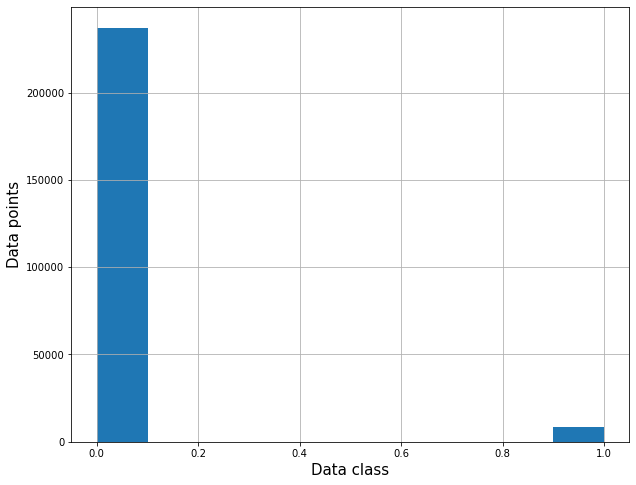

In [14]:
y_train.hist(figsize=(10,8))
plt.xlabel('Data class',fontsize=15)
plt.ylabel('Data points',fontsize=15)
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 
plt.savefig('fig21_1.pdf')

#### The classes after sampling:

In [15]:
sme = SMOTEENN(sampling_strategy='all')
resample_x, resample_y = sme.fit_resample(x_train, y_train)

In [16]:
resample_y.value_counts()

1    235552
0    218320
Name: Anomaly, dtype: int64

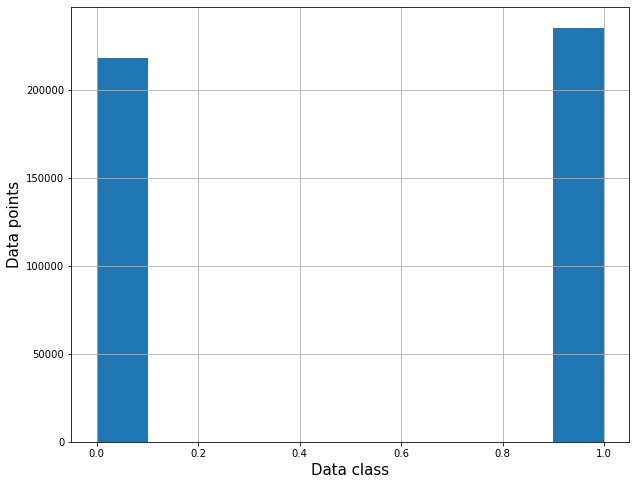

In [17]:
resample_y.hist(figsize=(10,8))
plt.xlabel('Data class',fontsize=15)
plt.ylabel('Data points',fontsize=15)
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 
plt.savefig('fig21_2.pdf')

# Evaluating Matrices:

In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

'''In imbalanced datasets, the goal is to improve recall without hurting precision.'''

def evaluation(y_true,y_pred,y_pred_proba):
    
    con_matrix = confusion_matrix(y_true, y_pred)
    tn,fp,fn,tp =con_matrix.flat
    
    classes=[0,1]
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(con_matrix), annot=True,fmt='g', cmap="Blues")
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)
    plt.title('Confusion matrix')
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()
    
    #==================================================================
    
    Sensitivity = round(tp/(tp+fn),3)
    Specificity = round(tn/(tn+fp),3)
    G_mean=round(np.sqrt(Sensitivity*Specificity),3)
    print("\nSensitivity = Recall", Sensitivity,"\nSpecificity ",Specificity,"\nG_mean ",G_mean)
    fp_rate = round(fp/(fp+tn),3)
    print("\n False positive rate", fp_rate )
    print("\n True positive Rate ",Sensitivity)
    F2 = round(fbeta_score(y_true, y_pred, average='binary', beta=2),3)
    print("\n F2-score",F2)
    
    #===================================================================

    print("\n\n\n The classification_report")
    print(classification_report(y_true,y_pred, labels=[0,1]))    

    #==================================================================
    
    P =round(precision_score(y_true, y_pred, average='weighted'),3)
    R = round(recall_score(y_true, y_pred, average='weighted'),3)
    F1 = round(f1_score(y_true, y_pred, average='weighted'),3)
    roc_auc = []
    if (np.array_equal(y_pred_proba,np.array([]))) != True:
        print("\n ROC curve + AUC score")
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = round(roc_auc_score(y_true, y_pred_proba),3)
        plt.plot(fpr,tpr,label="AUC="+str(roc_auc),marker='.')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.show()

    #===================================================================
    
    scores=dict()
    scores['Sensitivity']=Sensitivity
    scores['Specificity']=Specificity
    scores['G_mean']=G_mean
    scores['False_positive_rate']=fp_rate
    scores['Precision']=P
    scores['Recall']=R
    scores['F1-score']=F1
    scores['F2-score']=F2
    scores['roc_auc_score']=roc_auc
    
    return scores

# ==========================================

# Cost-Sensitive Logistic Regression :

#### Calculat class wights:
* weighting = n samples /(n classes × n samples with class)

In [19]:
weighting = compute_class_weight('balanced',[0,1], y_train.values) 
print(weighting)

[ 0.5177796  14.56106237]


/Users/eserrari/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### Training models comparison: 

The comparison based on mean F1-score, and runing time of training set.

- Class weighted Logistic Regression model.
- Class weighted Logistic Regression model with only SMOTEENN resampling.
- Class weighted Logistic Regression model with SMOTEENN resampling and rescaling.
- Class weighted Logistic Regression model with only rescaling.

In [ ]:
start = time.time()
model_1 = LogisticRegression(class_weight='balanced',max_iter=5000)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_1, x_train, y_train, scoring='f1', cv=cv) 
print('Mean F1_score: %.3f' % np.mean(scores))
print("Logistic Regression with original data is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_2 = LogisticRegression(class_weight='balanced',max_iter=5000)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_2, resample_x, resample_y, scoring='f1', cv=cv)  
print('Mean F1_score: %.3f' % np.mean(scores))
print("Logistic Regression with resamling method is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_3 = LogisticRegression( class_weight='balanced',max_iter=5000)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scale = StandardScaler()
pipeline = Pipeline(steps=[('scale', scale), ('model', model_3)])
scores = cross_val_score(pipeline, resample_x, resample_y, scoring='f1', cv=cv)  
print('Mean F1_score: %.3f' % np.mean(scores))
print("Logistic Regression with resmapling and rescaling method is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_4 = LogisticRegression( class_weight='balanced',max_iter=5000)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
pipeline_1 = Pipeline(steps=[('scale', scale), ('model', model_4)])
scores = cross_val_score(pipeline_1, x_train, y_train, scoring='f1', cv=cv)  
print('Mean F1_score: %.3f' % np.mean(scores))
print("Logistic Regression with resmapling and rescaling method is done in %0.2fs" % (time.time() - start))

### Hyperparameter Tuning for LogisticRegression:

* ####  Using Grid Search Hyperparameter Tuning:

In [ ]:
start = time.time()
LR_model = LogisticRegression(max_iter=5000,multi_class='ovr',verbose=True)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
balance = [{0:10,1:1}, {0:1,1:1}, {0:1,1:10},'balanced']
param_grid = dict(model__class_weight=balance)
param_grid['model__C'] = [0.01, 0.1, 1, 10]
param_grid['model__solver'] = ['lbfgs', 'liblinear','saga']
param_grid['model__penalty'] = ['l1', 'l2']
scaling =StandardScaler()
pipe = Pipeline(steps=[('scaler', scaling), ('model', LR_model)])
search = GridSearchCV(pipe, param_grid ,scoring='f1', cv=cv)
best_model = search.fit(resample_x, resample_y)
end = time.time()

print('Best F1-Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print('Time consumed is: ',end - start)

- The Grid search took long time to give  the best results, the time consumed was 3583.01s.
- The F1-score for the best Parameters of the grid search was 0.959.
- The best parameters of the grid search was:
    {'model__C': 0.01,
     'model__class_weight': {0: 1, 1: 1},
     'model__penalty': 'l1',
     'model__solver': 'saga'}

In [ ]:
best_model.best_score_

In [ ]:
best_model.best_params_

* #### Evaluate Logistic Regression model with the grid search's best parameters:

In [ ]:
scale = StandardScaler()
scale_resample_x=scale.fit_transform(resample_x)
scale_resample_x=scale.transform(resample_x)
scale_x_test= scale.transform(x_test)

start =time.time()
LR_model = LogisticRegression(class_weight={0: 1, 1: 1},C=0.01,solver='saga',penalty='l1',max_iter=5000
                              ,multi_class='ovr').fit(scale_resample_x, resample_y)
y_pred =LR_model.predict(scale_x_test)
y_pred_proba=LR_model.predict_proba(scale_x_test)[::,1]
LR_run_time = time.time() - start
print("done in %0.3fs" % LR_run_time)

In [ ]:
LR_scores = evaluation(y_test,y_pred,y_pred_proba)

* #### Using Bayesian Hyperparameter Optimization Tuning:

* The reference of this part of code is: 
    - https://maelfabien.github.io/machinelearning/HyperOpt/#
    - https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Bayesian%20Hyperparameter%20Optimization%20of%20Gradient%20Boosting%20Machine.ipynb

In [ ]:
N_FOLDS = 10
MAX_EVALS = 25
space = {
    'class_weight': hp.choice('class_weight', ['balanced',{0:10,1:1}, {0:1,1:1}, {0:1,1:10}]),
    'penalty' : hp.choice('penalty', ['l1', 'l2']),
    'C' : hp.choice('C', [0.01, 0.1, 1, 10]),
    'solver' : hp.choice('solver', ['lbfgs', 'liblinear', 'saga']),
}

In [ ]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on f1-score
    start = time.time()
    LR_model = LogisticRegression(**params,verbose =0,max_iter=5000) #,class_weight='balanced'
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scale = StandardScaler()
    pipeline = Pipeline(steps=[('scale', scale), ('model', LR_model)])
    scores = cross_val_score(LR_model, resample_x, resample_y, cv=cv, scoring='f1')  
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = 1 - best_score
    run_time = time.time()-start
    
    return {'loss': loss, 'params': params, 'best_score':best_score,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:

'''The tuning time consumed is 1486.813s'''

# Tree Parzen Estimators Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
LR_bayes_trials = Trials()

# Optimize
best_parms = fmin(fn = objective, space = space, algo = tpe.suggest,
                  max_evals = MAX_EVALS, trials = LR_bayes_trials)

The Trials object attribute (.results) hold all the objective function information. Therefore, we'll get the best hyperparameters that performed the most desirable when we sort it by lowest loss score.

In [ ]:
# Sort the trials results by lowest loss (highest F-score) first
LR_bayes_trials_results = sorted(LR_bayes_trials.results, key = lambda x: x['loss'])
LR_best_params = LR_bayes_trials_results[0]['params']
print("Best parameters",LR_best_params)
print("The train time consumed %0.3fs" % LR_bayes_trials_results[0]['train_time'])

In [ ]:
LR_all_time = sum([LR_bayes_trials_results[i]['train_time'] for i in range(len(LR_bayes_trials_results))])
print("The tuning time consumed %0.3fs" % LR_all_time)

* #### Evaluate Logistic Regression model with the bayesian optimization's best parameters:

In [20]:
LR_best_params = {'C': 0.01, 'class_weight': {0:1,1:1}, 'penalty': 'l1', 'solver': 'saga'}
scale = StandardScaler()
scale_resample_x=scale.fit_transform(resample_x)
scale_resample_x=scale.transform(resample_x)#,class_weight='balanced'
scale_x_test= scale.transform(x_test)

start =time.time()
LR_model = LogisticRegression(**LR_best_params,max_iter=5000,
                              multi_class='ovr').fit(scale_resample_x, resample_y)
LR_y_pred =LR_model.predict(scale_x_test)
LR_y_pred_proba=LR_model.predict_proba(scale_x_test)[::,1]
LR_run_time = time.time() - start
print("done in %0.3fs" % LR_run_time)

done in 2.422s


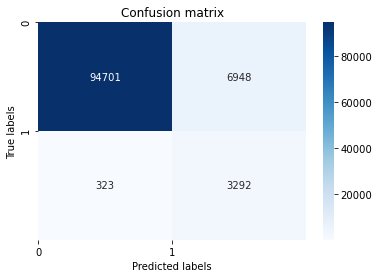


Sensitivity = Recall 0.911 
Specificity  0.932 
G_mean  0.921

 False positive rate 0.068

 True positive Rate  0.911

 F2-score 0.666



 The classification_report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    101649
           1       0.32      0.91      0.48      3615

    accuracy                           0.93    105264
   macro avg       0.66      0.92      0.72    105264
weighted avg       0.97      0.93      0.95    105264


 ROC curve + AUC score


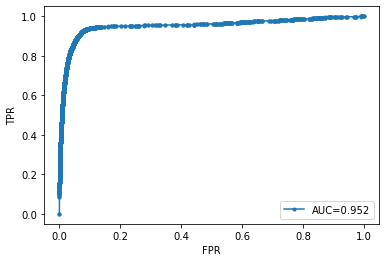

In [21]:
LR_scores = evaluation(y_test,LR_y_pred,LR_y_pred_proba)

### Note:
Both tuning methods' best parameters have similar scores. However, the grid search took away long time to finish.

# ===============================================

# DBSCAN:

#### DBSCAN using heuristics parameters:

- The reference for choosing min_samples parameter is: "DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN",https://dl.acm.org/doi/abs/10.1145/3068335.
- They suggested using minPts = 2 · dim, which means in our case 2 * 8 = 16.
- The reference for choosing eps parameter is: "Multivariate weather anomaly detection using DBSCAN clustering algorithm", https://iopscience.iop.org/article/10.1088/1742-6596/1869/1/012077
- We'll use 'knee in the KNN distance plot to identify eps.
- the reference of Kneelocator code is: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62.

In [22]:
def get_eps(x,min_Pts):
    NN = NearestNeighbors(n_neighbors=min_Pts)
    neighbors_n = NN.fit(x)
    dist, _ = neighbors_n.kneighbors(x)
    distances = np.sort(dist[:,min_Pts-1], axis=0)
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    fig = plt.figure(figsize=(5, 5))
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    eps = round(distances[knee.knee],3)
    print("eps is %0.3f" %eps)
    return eps

#### First, we run DBSCAN on original data:

In [ ]:
eps = get_eps(x_train,x_train.shape[1]*2)
start = time.time()
clustering = DBSCAN(eps = eps, min_samples = x_train.shape[1]*2).fit(x_train)
anom_index = np.where(clustering.labels_ == -1)[0]
anom_values = np.zeros(shape=y_train.shape)
anom_values[anom_index]=1
f1 = f1_score(y_train, anom_values, average='binary') # "binary" => Only report results for the positive class
print('F1_score for postive class: %.3f' % f1)
print("DBSCAN with original data is done in %0.2fs" % (time.time() - start))

#### Second, we run DBSCAN on Standardised data:

In [23]:
scaler = StandardScaler()
x_scale_train = scaler.fit_transform(x_train)
scale_train = pd.DataFrame(x_scale_train)
scale_train.columns = x_train.columns.tolist()

<Figure size 360x360 with 0 Axes>

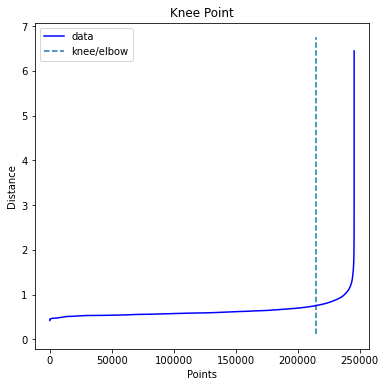

eps is 0.752
F1_score for postive class: 0.575
DBSCAN with standardised data is done in 57.95s


In [24]:
eps = get_eps(scale_train,scale_train.shape[1]*2)
start = time.time()
clustering = DBSCAN(eps = eps, min_samples = scale_train.shape[1]*2).fit(scale_train)
anom_index = np.where(clustering.labels_ == -1)[0]
anom_values = np.zeros(shape=y_train.shape)
anom_values[anom_index]=1
f1 = f1_score(y_train, anom_values, average='binary')# "binary" => Only report results for the positive class
print('F1_score for postive class: %.3f' % f1)
print("DBSCAN with standardised data is done in %0.2fs" % (time.time() - start))

# ============================

### Hyperparameter Tuning for DBSCAN:

* #### Using Grid Search Hyperparameter Tuning:

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x_train)
y = y_train.to_numpy()

In [ ]:
def cross_validation_function(params,x,y):
    fold_index = RepeatedStratifiedKFold(n_splits=10, n_repeats=1,random_state=4)
    scores = []
    for train_index, test_index in fold_index.split(x,y):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = DBSCAN(**params).fit(X_train)
        labels = model.fit_predict(X_test)
        anom_index = np.where(labels == -1)[0]
        y_pred = np.zeros(shape=y_test.shape)
        y_pred[anom_index]=1
        f1 = round(f1_score(y_test, y_pred, average='binary'),3)
        scores.append(f1)
    return round(np.mean(scores),3)

In [ ]:
'''The tuning time consumed 21485.940s'''
param_grid = dict()
param_grid['eps'] = [0.3,0.6,0.8,1.0,1.5]
param_grid['min_samples'] = [12,16,24,27,32]

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
f1_s = []
run_time = []

for params in all_params:
    print("params",params)
    start = time.time()
    score = cross_validation_function(params,x,y)
    run_time.append(time.time() - start)
    f1_s.append(score)

In [ ]:
DBSCAN_best_params = all_params[np.argmax(f1_s)]
print("Best parameters",DBSCAN_best_params)
print("The tuning time consumed %0.3fs" % sum(run_time))

* #### Evaluate DBSCAN model with the grid search's best parameters:

In [ ]:
DBSCAN_best_params={'eps': 1.5, 'min_samples': 32}

scale = StandardScaler()
scale_x_train = scale.fit_transform(x_train)
scale_x_test= scale.transform(x_test)

start =time.time()
DBSCAN_model = DBSCAN(**DBSCAN_best_params).fit(scale_x_train)
labels = DBSCAN_model.fit_predict(scale_x_test)
anom_index = np.where(labels == -1)[0]
DBSCAN_y_pred = np.zeros(shape=y_test.shape)
DBSCAN_y_pred[anom_index]= 1
DBSCAN_run_time = time.time() - start
print("done in %0.3fs" % DBSCAN_run_time)

In [ ]:
DBSCAN_scores = evaluation(y_test,DBSCAN_y_pred,y_pred_proba=np.array([]))

* #### Using Bayesian Hyperparameter Optimization Tuning:

In [ ]:
N_FOLDS = 10
MAX_EVALS = 25
space = {
    'eps' : hp.choice('eps', [0.3,eps,1.0,1.5,2.0]),
    'min_samples' : hp.choice('min_samples', [8,16,20,24,32]),
}

In [ ]:
def score_function(model,x, y):
    model = model.fit(x)
    labels = model.labels_
    anom_index = np.where(labels == -1)[0]
    y_pred = np.zeros(shape=y.shape)
    y_pred[anom_index]=1
    score = f1_score(y, y_pred, pos_label=1,average='binary') 
    return score

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x_train)
y = y_train.to_numpy()

In [ ]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for DBSCAN Hyperparameter Tuning"""
    start = time.time()
    model = DBSCAN(**params)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
    scores = cross_val_score(model, x, y, cv=cv, scoring=score_function)  
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = 1 - best_score
    run_time = time.time()-start
    
    return {'loss': loss, 'params': params,'best_score':best_score,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
'''The tuning time consumed 2185.091s'''

# Tree Parzen Estimators Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
DB_bayes_trials = Trials()

# Optimize
best_parms = fmin(fn = objective, space = space, algo = tpe.suggest,
                  max_evals = MAX_EVALS, trials = DB_bayes_trials)

In [ ]:
# Sort the trials results by lowest loss (highest F-score) first
DB_bayes_trials_results = sorted(DB_bayes_trials.results, key = lambda x: x['loss'])
DB_best_params = DB_bayes_trials_results[0]['params']
print("Best parameters",DB_best_params)
print("The tuning time consumed %0.3fs" % DB_bayes_trials_results[0]['train_time'])

* #### Evaluate DBSCAN model with the bayesian optimization's best parameters:

In [ ]:
DBSCAN_best_params={'eps': 1.5, 'min_samples': 32}

scale = StandardScaler()
scale_x_train = scale.fit_transform(x_train)
scale_x_test= scale.transform(x_test)

start =time.time()
DBSCAN_model = DBSCAN(**DBSCAN_best_params).fit(scale_x_train)
labels = DBSCAN_model.fit_predict(scale_x_test)
anom_index = np.where(labels == -1)[0]
DBSCAN_y_pred = np.zeros(shape=y_test.shape)
DBSCAN_y_pred[anom_index]= 1
DBSCAN_run_time = time.time() - start
print("done in %0.3fs" % DBSCAN_run_time)

In [ ]:
DBSCAN_scores = evaluation(y_test,DBSCAN_y_pred,y_pred_proba=np.array([]))

### Evaluate DBSCAN model with the heuristics parameters:

In [25]:
scale = StandardScaler()
scale_x_train = scale.fit_transform(x_train)
scale_x_test= scale.transform(x_test)
DBSCAN_best_params={'eps': eps, 'min_samples': 16}
start =time.time()
DBSCAN_model = DBSCAN(**DBSCAN_best_params).fit(scale_x_train)
labels = DBSCAN_model.fit_predict(scale_x_test)
anom_index = np.where(labels == -1)[0]
DBSCAN_y_pred = np.zeros(shape=y_test.shape)
DBSCAN_y_pred[anom_index]= 1
DBSCAN_run_time = time.time() - start
print("done in %0.3fs" % DBSCAN_run_time)

done in 66.123s


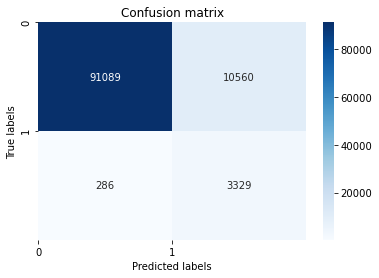


Sensitivity = Recall 0.921 
Specificity  0.896 
G_mean  0.908

 False positive rate 0.104

 True positive Rate  0.921

 F2-score 0.587



 The classification_report
              precision    recall  f1-score   support

           0       1.00      0.90      0.94    101649
           1       0.24      0.92      0.38      3615

    accuracy                           0.90    105264
   macro avg       0.62      0.91      0.66    105264
weighted avg       0.97      0.90      0.92    105264



In [26]:
DBSCAN_scores = evaluation(y_test,DBSCAN_y_pred,y_pred_proba=np.array([]))

# ================================================

# Ensemble Random Forest Classifier:

### Training models comparison: 

The comparison based on mean F1-score, and runing time of training set.

- Standard Random Forest model.
- Standard Random Forest model with SMOTEENN resampling.
- Random Forest model with class weighting.
- Random Forest model with SMOTEENN resampling and class weighting.
- Random Forest model with Bootstrap class weighting.
- Random Forest model with SMOTEENN resampling and Bootstrap class weighting.
- Random Forest model with Random Undersampling.

In [ ]:
start = time.time()
model = RandomForestClassifier(n_estimators=100,random_state=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, x_train, y_train, scoring='f1', cv=cv) 
print('Mean F1_score: %.3f' % np.mean(scores))
print("Standard Random Forest Classifier with original data is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_0 = RandomForestClassifier(n_estimators=100,random_state=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_0, resample_x, resample_y, scoring='f1', cv=cv) 
print('Mean F1_score: %.3f' % np.mean(scores))
print("Standard Random Forest Classifier with resampled data is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_1 = RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_1, x_train, y_train, scoring='f1', cv=cv) 
print('Mean F1_score: %.3f' % np.mean(scores))
print("Random Forest Classifier with original data is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_2 = RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_2, resample_x, resample_y, scoring='f1', cv=cv) 
print('Mean F1_score: %.3f' % np.mean(scores))
print("Random Forest Classifier with resampled data is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_3 = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample',random_state=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_3, x_train, y_train, scoring='f1', cv=cv)
print('Mean F1_score: %.3f' % np.mean(scores))
print("Random Forest Classifier with original data and Bootstrap Class Weighting is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_4 = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample',random_state=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_4, resample_x, resample_y, scoring='f1', cv=cv)
print('Mean F1_score: %.3f' % np.mean(scores))
print("Random Forest Classifier with resampeld data and bootstrap is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_5 = BalancedRandomForestClassifier(n_estimators=100,random_state=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_5, x_train, y_train, scoring='f1', cv=cv)
print('Mean F1_score: %.3f' % np.mean(scores))
print("Random Forest Classifier with Random Undersampling is done in %0.2fs" % (time.time() - start))

### Hyperparameter Tuning for Random Forest:

In [ ]:
N_FOLDS = 10
MAX_EVALS = 25
space = {
    'n_estimators' : hp.choice('n_estimators', [10,50,100]),
    'criterion' : hp.choice('criterion', ['gini','entropy']),
    'max_depth' : hp.choice('max_depth', [None,3,9,12]),
    'min_samples_split' : hp.choice('min_samples_split',[2,10,20]),
    'min_samples_leaf' : hp.choice('min_samples_leaf',[1,10,20]),
    'max_features' : hp.choice('max_features',['sqrt', 'log2']),
    'class_weight' : hp.choice('class_weight',['balanced', 'balanced_subsample'])
}

In [ ]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for Random Forest Hyperparameter Tuning"""
    start = time.time()
    RF_model = RandomForestClassifier(**params,random_state=4)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(RF_model, resample_x, resample_y, cv=cv, scoring='f1')  
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = 1 - best_score
    run_time = time.time()-start
    
    return {'loss': loss, 'params': params,'best_score':best_score,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
'''The tuning time consumed  16600.093s'''
# Tree Parzen Estimators Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
RF_bayes_trials = Trials()

# Optimize
best_parms = fmin(fn = objective, space = space, algo = tpe.suggest,
                  max_evals = MAX_EVALS, trials = RF_bayes_trials)

In [ ]:
# Sort the trials results by lowest loss (highest F-score) first
RF_bayes_trials_results = sorted(RF_bayes_trials.results, key = lambda x: x['loss'])
RF_best_params = RF_bayes_trials_results[0]['params']
print("Best parameters",RF_best_params)
print("The train time consumed %0.3fs" % RF_bayes_trials_results[0]['train_time'])

In [ ]:
RF_all_time = sum([RF_bayes_trials_results[i]['train_time'] for i in range(len(RF_bayes_trials_results))])
print("The tuning time consumed %0.3fs" % RF_all_time)

#### Evaluate Random Forest model with the bayesian optimization's best parameters:

In [27]:
RF_params = {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None,
             'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
start =time.time()
RF_model = RandomForestClassifier(**RF_params).fit(resample_x,resample_y)
RF_y_pred =RF_model.predict(x_test)
RF_y_pred_proba=RF_model.predict_proba(x_test)[::,1]
RF_run_time = time.time() - start
print("done in %0.3fs" % RF_run_time)

done in 51.874s


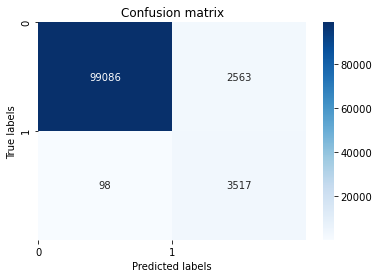


Sensitivity = Recall 0.973 
Specificity  0.975 
G_mean  0.974

 False positive rate 0.025

 True positive Rate  0.973

 F2-score 0.856



 The classification_report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    101649
           1       0.58      0.97      0.73      3615

    accuracy                           0.97    105264
   macro avg       0.79      0.97      0.86    105264
weighted avg       0.98      0.97      0.98    105264


 ROC curve + AUC score


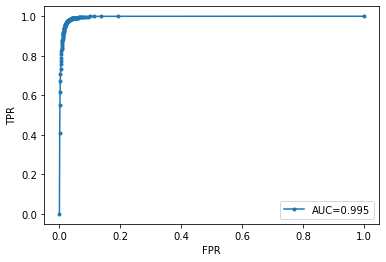

In [28]:
RF_scores = evaluation(y_test,RF_y_pred,RF_y_pred_proba)

# =============================================

# Isolation Forest:

### Training models comparison: 

The comparison based on mean F1-score, and runing time of training set.

- Isolation Forest model with the original data.
- Isolation Forest model with majority class only.


In [29]:
'''We split the data to a train and validat sets'''
train_X, val_X, train_y, val_y = train_test_split(x_train, y_train, test_size=0.75, random_state=4, stratify=y_train)
'''To fit the model on majority class only'''
major_X = train_X[train_y == 0]

In [ ]:
start = time.time()
model_1 = IsolationForest(contamination=0.01,random_state=4).fit(train_X)
y_pred = model_1.predict(val_X)
''' We change the labels of the predicted set  to 0s and 1s before evaluating, since
the model will predict an inlier with a label of +1 and an outlier with a label of -1'''
y_pred[y_pred==1]=0
y_pred[y_pred==-1]=1

score = f1_score(val_y, y_pred, pos_label=1,average='binary') 
print('F-measure: %.3f' % score)
print("Isolation Forest with original data is done in %0.2fs" % (time.time() - start))

In [ ]:
start = time.time()
model_2 = IsolationForest(contamination=0.01,random_state=4).fit(major_X)
y_pred = model_2.predict(val_X)
y_pred[y_pred==1]=0
y_pred[y_pred==-1]=1

score = f1_score(val_y, y_pred, pos_label=1,average='binary') 
print('F-measure: %.3f' % score)
print("Isolation Forest with majority class is done in %0.2fs" % (time.time() - start))

### Hyperparameter Tuning for Isolation Forest:

In [ ]:
N_FOLDS = 10
MAX_EVALS = 25
space = {
    'n_estimators' : hp.choice('n_estimators', [50,100,150,200]),
    'max_samples' : hp.choice('max_samples', ['auto',0.25,0.5,0.75,0.9]),
    'contamination' : hp.choice('contamination', ['auto',0.001,0.01,0.1,0.5]),
    'max_features' : hp.choice('max_features',[1,3,8]),
    'bootstrap' : hp.choice('bootstrap',[True,False])
}

In [ ]:
def score_function(model,x, y):
    model = model.fit(x)
    y_pred = model.fit_predict(x)
    y_pred[y_pred==1]=0
    y_pred[y_pred==-1]=1
    score = f1_score(y, y_pred, pos_label=1,average='binary') 
    return score

In [ ]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for Isolation Forest Hyperparameter Tuning"""
    start = time.time()
    IF_model = IsolationForest(**params,random_state=4)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(IF_model, x_train, y_train, cv=cv, scoring=score_function)  
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = 1 - best_score
    run_time = time.time()-start
    
    return {'loss': loss, 'params': params,'best_score':best_score,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
'''The tuning time consumed 8718.364s'''

# Tree Parzen Estimators Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
IF_bayes_trials = Trials()

# Optimize
best_parms = fmin(fn = objective, space = space, algo = tpe.suggest,
                  max_evals = MAX_EVALS, trials = IF_bayes_trials)

In [ ]:
# Sort the trials results by lowest loss (highest F-score) first
IF_bayes_trials_results = sorted(IF_bayes_trials.results, key = lambda x: x['loss'])
IF_best_params = IF_bayes_trials_results[0]['params']
print("Best parameters",IF_best_params)
print("The train time consumed %0.3fs" % IF_bayes_trials_results[0]['train_time'])

In [ ]:
IF_all_time = sum([IF_bayes_trials_results[i]['train_time'] for i in range(len(IF_bayes_trials_results))])
print("The tuning time consumed %0.3fs" % IF_all_time)

#### Evaluate Isolation Forest model with the bayesian optimization's best parameters:

In [30]:
IF_params = {'bootstrap': False, 'contamination': 0.1, 'max_features': 3, 'max_samples': 0.25, 'n_estimators': 100}
major_x = x_train[y_train == 0]
start =time.time()
IF_model = IsolationForest(**IF_params,random_state=4).fit(major_x)
IF_y_pred = IF_model.predict(x_test)
IF_y_pred[IF_y_pred==1]=0
IF_y_pred[IF_y_pred==-1]=1
IF_y_pred_score= 1-IF_model.score_samples(x_test)
IF_run_time = time.time() - start
print("done in %0.3fs" % IF_run_time)

done in 18.977s


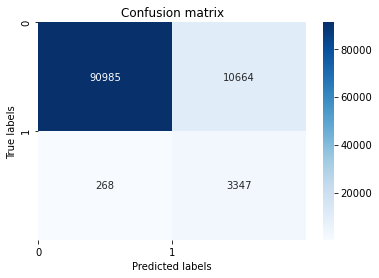


Sensitivity = Recall 0.926 
Specificity  0.895 
G_mean  0.91

 False positive rate 0.105

 True positive Rate  0.926

 F2-score 0.588



 The classification_report
              precision    recall  f1-score   support

           0       1.00      0.90      0.94    101649
           1       0.24      0.93      0.38      3615

    accuracy                           0.90    105264
   macro avg       0.62      0.91      0.66    105264
weighted avg       0.97      0.90      0.92    105264


 ROC curve + AUC score


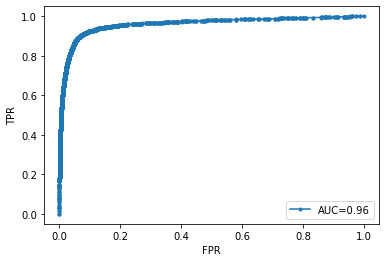

In [31]:
IF_scores = evaluation(y_test,IF_y_pred,IF_y_pred_score)


# =======================================

# Models' results:

In [32]:
Models = {'Logistic Regression':LR_scores,
          'DBSCAN':DBSCAN_scores,
          'Random Forest':RF_scores,
          'Isolation Forest':IF_scores}

print("{:<20} | {:<15} | {:<15} | {:<15}".format('Model', 'Sensitivity', 'Specificity','G_mean'))
for k,v in Models.items():
    print("{:<20} | {:<15} | {:<15} | {:<15}".format(k,v['Sensitivity'], v['Specificity'],v['G_mean']))

Model                | Sensitivity     | Specificity     | G_mean         
Logistic Regression  | 0.911           | 0.932           | 0.921          
DBSCAN               | 0.921           | 0.896           | 0.908          
Random Forest        | 0.973           | 0.975           | 0.974          
Isolation Forest     | 0.926           | 0.895           | 0.91           


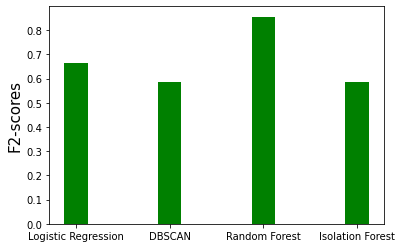

In [34]:
F2_scores = {'Logistic Regression':LR_scores['F2-score'],
          'DBSCAN':DBSCAN_scores['F2-score'],
          'Random Forest':RF_scores['F2-score'],
          'Isolation Forest':IF_scores['F2-score']}
plt.bar(*zip(*F2_scores.items()),color='g',width = 0.25)
#plt.title("F2-scores \n")
#plt.xlabel('Data class',fontsize=15)
plt.ylabel('F2-scores',fontsize=15)
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 
#plt.savefig('fig22.pdf')
plt.show()

#### Note:
The scores below are weighted scores, which means we calculate metrics for each label, 
and find their average weighted by support (the number of true instances for each label).

In [35]:
print("{:<20} | {:<15} | {:<15} | {:<15}".format('Model', 'Recall', 'Precision','F1-score'))
for k,v in Models.items():
    print("{:<20} | {:<15} | {:<15} | {:<15}".format(k,v['Recall'], v['Precision'],v['F1-score']))
    

Model                | Recall          | Precision       | F1-score       
Logistic Regression  | 0.931           | 0.973           | 0.946          
DBSCAN               | 0.897           | 0.971           | 0.924          
Random Forest        | 0.975           | 0.985           | 0.978          
Isolation Forest     | 0.896           | 0.971           | 0.924          


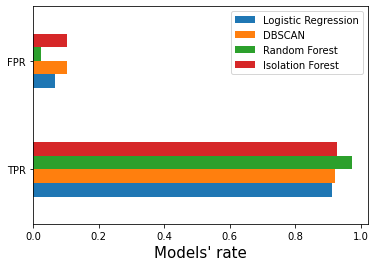

In [39]:
Rates = {'Logistic Regression':{'TPR':LR_scores['Sensitivity'],'FPR':LR_scores['False_positive_rate']},
          'DBSCAN':{'TPR':DBSCAN_scores['Sensitivity'],'FPR':DBSCAN_scores['False_positive_rate']},
          'Random Forest':{'TPR':RF_scores['Sensitivity'],'FPR':RF_scores['False_positive_rate']},
          'Isolation Forest':{'TPR':IF_scores['Sensitivity'],'FPR':IF_scores['False_positive_rate']}}

pd.DataFrame(Rates).plot(kind='barh')
plt.xlabel("Models' rate",fontsize=15)
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 
#plt.title("True positive rate/ False positive rate for each model \n")
#plt.savefig('fig23.pdf')
plt.show()

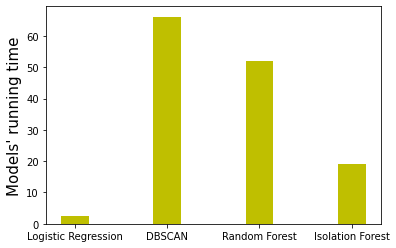

In [40]:
run_times = {'Logistic Regression':LR_run_time,
          'DBSCAN':DBSCAN_run_time,
          'Random Forest':RF_run_time,
          'Isolation Forest':IF_run_time}
plt.bar(*zip(*run_times.items()),color='y',width = 0.30)
#plt.title("Models' running time")
plt.ylabel("Models' running time",fontsize=15)
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 
#plt.savefig('fig25.pdf')
plt.show()

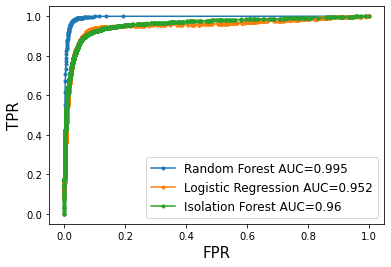

In [42]:
curves = {'Random Forest':[RF_y_pred,RF_y_pred_proba],
          'Logistic Regression':[LR_y_pred,LR_y_pred_proba],
          'Isolation Forest':[IF_y_pred,IF_y_pred_score]}
for k,v in curves.items():
    fpr, tpr, _ = roc_curve(y_test, v[1])
    roc_auc = round(roc_auc_score(y_test, v[1]),3)
    plt.plot(fpr,tpr,label=k+" AUC="+str(roc_auc),marker='.')
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.legend(fontsize="large")
#plt.title(" ROC Curve and AUC score")
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 
#plt.savefig('fig24.pdf')
plt.show()

# =========================================